In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
mp.matplotlib_fname()

from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import sklearn.pipeline as pl
import sklearn.preprocessing as sp
import sklearn.linear_model as lm
import sklearn.metrics as sm

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.notebook_repr_html', False)

In [2]:
excel1 = pd.read_excel(io='../data/附件1.xlsx', sheet_name='Sheet1')

def df2List(tabel):
    df = excel1[[tabel]]
    _array = np.array(df.stack())
    _list = _array.tolist()
    return _list

# 单品名称列表
name_list = df2List('单品名称')
# 分类名称列表
class_name_list = df2List('分类名称')

# 单品名称2分类名称哈希表
name2class = {}
for i in range(len(name_list)):
    name2class[name_list[i]] = class_name_list[i]

In [3]:
weight = pd.read_csv('../data/sell_weight.csv')[-283::]
earn = pd.read_csv('../data/earn_daily.csv')[-283::]
# 创建单品编码与单品名称哈希表
lost = pd.read_excel(io='../data/附件4.xlsx', sheet_name='Sheet1')

In [4]:
need = pd.DataFrame({
    "水生根茎类":[10.618191],   
    "花叶类": [185.167241],
    "花菜类": [41.569375],
    "茄类": [28.143449], 
    "辣椒类": [56.647898],
    "食用菌": [42.880418]
})
need

       水生根茎类         花叶类        花菜类         茄类        辣椒类        食用菌
0  10.618191  185.167241  41.569375  28.143449  56.647898  42.880418

In [5]:
weight_total = weight.drop('销售日期', axis=1).groupby('单品编码', as_index=False).sum()
earn_total = earn.drop('销售日期', axis=1).groupby('单品编码', as_index=False).sum()
weight_total, earn_total

(            单品编码   销量(千克)
 0         七彩椒(2)    7.302
 1            上海青   27.029
 2          云南油麦菜    5.098
 3       云南油麦菜(份)  149.000
 4           云南生菜   11.683
 5        云南生菜(份)  226.000
 6          净藕(1)   42.184
 7         双孢菇(盒)   70.000
 8         圆茄子(2)    7.443
 9           外地茼蒿    6.538
 10           奶白菜   44.959
 11  姜蒜小米椒组合装(小份)   49.000
 12           娃娃菜   73.000
 13        小皱皮(份)   79.000
 14        小米椒(份)  150.000
 15        小青菜(1)   34.306
 16           木耳菜   41.534
 17        木耳菜(份)    3.000
 18        枝江青梗散花   25.203
 19          洪湖藕带   28.232
 20        海鲜菇(包)   62.000
 21        白玉菇(袋)    4.000
 22           竹叶菜   93.077
 23        紫茄子(1)    1.024
 24        紫茄子(2)   76.320
 25         红椒(2)   14.250
 26          红莲藕带    4.596
 27           红薯尖   31.546
 28       芜湖青椒(1)   99.634
 29            苋菜   62.461
 30            菜心    8.877
 31            菠菜    6.820
 32         菠菜(份)   49.000
 33            菱角   12.224
 34        虫草花(份)   16.000
 35           螺丝椒   47.897
 

In [6]:
earn_rate_df = pd.DataFrame()
earn_rate_df['单品编码'] = weight_total['单品编码']
earn_rate_df['利润率(元/千克)'] = earn_total['利润(元)'] / weight_total['销量(千克)']

In [7]:
earn_rate_df = earn_rate_df.sort_values(by="利润率(元/千克)", ascending=False)
earn_rate_df = earn_rate_df.reset_index(drop=True)
earn_rate_df

            单品编码  利润率(元/千克)
0           野生粉藕   9.934092
1        西峡花菇(1)   8.400000
2         七彩椒(2)   6.828147
3          红椒(2)   5.818628
4            长线茄   5.014839
5             菱角   4.832460
6         紫茄子(1)   4.660000
7            西兰花   4.586283
8             菠菜   4.364391
9           外地茼蒿   4.269792
10        枝江青梗散花   3.883782
11           上海青   3.869826
12           螺丝椒   3.827293
13        小米椒(份)   3.620333
14          红莲藕带   3.610816
15         净藕(1)   3.582122
16          云南生菜   3.460315
17          洪湖藕带   3.017250
18         云南油麦菜   2.824602
19        小青菜(1)   2.370185
20    青红杭椒组合装(份)   2.282667
21        紫茄子(2)   2.269642
22  姜蒜小米椒组合装(小份)   2.263673
23           奶白菜   2.253172
24        白玉菇(袋)   2.197500
25           木耳菜   2.190151
26        圆茄子(2)   2.188877
27         高瓜(2)   2.166945
28           红薯尖   2.138595
29        青茄子(1)   1.914143
30       芜湖青椒(1)   1.833340
31        木耳菜(份)   1.800000
32           娃娃菜   1.783836
33         高瓜(1)   1.702016
34        双孢菇(盒)   1

In [8]:
need_list = [["水生根茎类", "花叶类", "花菜类", "茄类", "辣椒类", "食用菌"],
             [10.618191, 185.167241, 41.569375, 28.143449, 56.647898, 42.880418]]

In [9]:
buy = pd.DataFrame(columns=['单品名称', '进货量(千克)'])
buy_list = [0, 0, 0, 0, 0, 0]
j = 0
while buy_list != need_list[1]:
    i = j % 49
    veg_index = need_list[0].index(name2class[earn_rate_df.loc[i]['单品编码']])
    if buy_list[veg_index] != need_list[1][veg_index]:
        if need_list[1][veg_index] - buy_list[veg_index] >= 2.5:
            buy_list[veg_index] += 2.5
            buy.loc[len(buy.index)] = [earn_rate_df.loc[i]['单品编码'], 2.5]
        elif need_list[1][veg_index] - buy_list[veg_index] == 0:
            j+=1
            continue
        elif need_list[1][veg_index] - buy_list[veg_index] < 2.5:
            buy.loc[len(buy.index)] = [earn_rate_df.loc[i]['单品编码'], need_list[1][veg_index] - buy_list[veg_index]]
            buy_list[veg_index] += need_list[1][veg_index] - buy_list[veg_index]
    j+=1

buy = buy.groupby('单品名称', as_index=False).sum()
buy.style

,单品名称,进货量(千克)
0,七彩椒(2),7.500000
1,上海青,12.500000
2,云南油麦菜,12.500000
3,云南油麦菜(份),10.000000
4,云南生菜,12.500000
5,云南生菜(份),10.000000
6,净藕(1),2.500000
7,双孢菇(盒),5.000000
8,圆茄子(2),5.000000
9,外地茼蒿,12.500000


综上，洪湖藕带不足2.5千克，舍去，换位同品类利润率最大的单品

In [10]:
for i in range(len(earn_rate_df)):
    if name2class[earn_rate_df.loc[i]['单品编码']] == name2class['洪湖藕带']:
        buy.loc[len(buy.index)] = [earn_rate_df.loc[i]['单品编码'], buy.loc[19].values.tolist()[1]]
        break
buy = buy.drop(19).groupby('单品名称', as_index=False).sum()
buy = pd.merge(buy,lost,on='单品名称',how='inner').drop('单品编码', axis=1)
buy.style

,单品名称,进货量(千克),损耗率(%)
0,七彩椒(2),7.500000,9.430000
1,上海青,12.500000,14.430000
2,云南油麦菜,12.500000,12.810000
3,云南油麦菜(份),10.000000,9.430000
4,云南生菜,12.500000,15.250000
5,云南生菜(份),10.000000,9.430000
6,净藕(1),2.500000,5.540000
7,双孢菇(盒),5.000000,0.200000
8,圆茄子(2),5.000000,6.710000
9,外地茼蒿,12.500000,26.160000


<Figure size 1080x576 with 0 Axes>

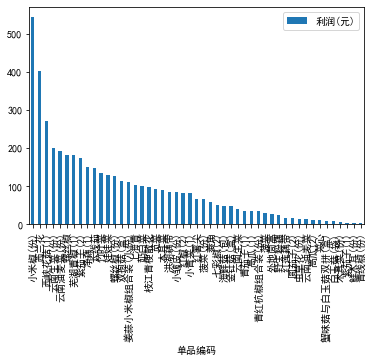

In [11]:
plt.figure(figsize=(15, 8))
earn_total.sort_values(by="利润(元)", ascending=False).set_index('单品编码').plot.bar()
plt.show()

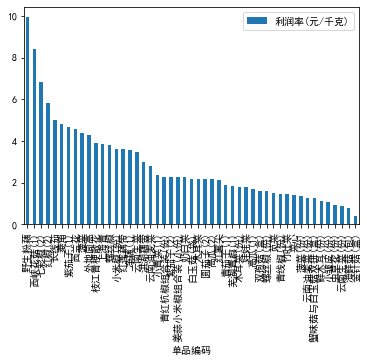

In [12]:
earn_rate_df.set_index('单品编码').plot.bar()
plt.show()